<a href="https://colab.research.google.com/github/AnslemDCunha/Global-Index-Returns-in-USD-A-Currency-Adjusted-Comparison/blob/main/Global_Index_Returns_Currency_Adjusted_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Index Returns in USD: A Currency-Adjusted Comparison

In [1]:
#Required libraries
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- Project Configuration ---

# Analysis Period
START_DATE = '2010-01-01'
END_DATE = '2025-06-01' # Using a recent date

# Top N economies to analyze
TOP_N_ECONOMIES = 15

# Year for GDP data to determine top economies
GDP_YEAR = '2023'

In [3]:
# Mapping of country names to their stock index tickers

COUNTRY_INDEX_MAP = {'United States': ('S&P 500', '^GSPC'),
                    'China': ('Shanghai Composite', '000001.SS'),
                    'Germany': ('DAX', '^GDAXI'),
                    'Japan': ('Nikkei 225', '^N225'),
                    'India': ('Nifty 50', '^NSEI'),
                    'United Kingdom': ('FTSE 100', '^FTSE'),
                    'France': ('CAC 40', '^FCHI'),
                    'Italy': ('FTSE MIB', 'FTSEMIB.MI'),
                    'Brazil': ('Bovespa', '^BVSP'),
                    'Canada': ('S&P/TSX Composite', '^GSPTSE'),
                    # 'Russian Federation': ('MOEX', 'IMOEX.ME'), # Often has data issues
                    'Australia': ('S&P/ASX 200', '^AXJO'),
                    'Mexico': ('IPC', '^MXX'),
                    'Spain': ('IBEX 35', '^IBEX'),
                    'Indonesia': ('IDX Composite', '^JKSE'),
                    'Netherlands': ('AEX', '^AEX'),
                    'Saudi Arabia': ('Tadawul All Share', '^TASI.SN'), # Corrected Ticker
                    'Switzerland': ('Swiss Market Index', '^SSMI'),
                    'Korea, Rep.': ('KOSPI', '^KS11')}

# Mapping of country names to their currency codes
COUNTRY_CURRENCY_MAP = {'United States': 'USD', 'China': 'CNY', 'Germany': 'EUR', 'Japan': 'JPY',
                        'India': 'INR', 'United Kingdom': 'GBP', 'France': 'EUR', 'Italy': 'EUR',
                        'Brazil': 'BRL', 'Canada': 'CAD', 'Australia': 'AUD', 'Mexico': 'MXN',
                        'Spain': 'EUR', 'Indonesia': 'IDR', 'Netherlands': 'EUR', 'Saudi Arabia': 'SAR',
                        'Switzerland': 'CHF', 'Korea, Rep.': 'KRW'}

In [5]:
def get_top_economies(year: str, top_n: int) -> pd.DataFrame:
    """
    Fetches GDP data from the World Bank and returns a DataFrame of the
    top N economies for a given year.
    """
    # URL for World Bank GDP data (current US$)
    url = "https://api.worldbank.org/v2/en/indicator/NY.GDP.MKTP.CD?downloadformat=excel"

    # Read data, skipping metadata rows at the top
    gdp_df = pd.read_excel(url, sheet_name='Data', skiprows=3)

    # Keywords to identify and exclude aggregate regions (e.g., "World", "Euro area")
    exclude_keywords = ["World", "income", "IBRD", "IDA", "OECD", "Euro area", "Arab World",
                        "Sub-Saharan", "Latin America", "Caribbean", "Africa", "Asia", "Europe",
                        "Middle East", "North America", "dividend", "Fragile"]

    # Filter out rows containing any of the exclusion keywords
    mask = ~gdp_df['Country Name'].str.contains('|'.join(exclude_keywords), case=False)
    countries_df = gdp_df[mask]

    # Select relevant columns and drop rows with no GDP data for the specified year
    countries_df = countries_df[['Country Name', year]].dropna()

    # Sort by GDP and get the top N
    top_countries = countries_df.sort_values(by=year, ascending=False).head(top_n)

    return top_countries.reset_index(drop=True)


top_economies = get_top_economies(year=GDP_YEAR, top_n=TOP_N_ECONOMIES)

top_economies

,Country Name,2023
0,United States,2.772071e+13
1,China,1.827036e+13
2,Germany,4.525704e+12
3,Japan,4.213167e+12
4,India,3.638489e+12
5,United Kingdom,3.369862e+12
6,France,3.051832e+12
7,Italy,2.304605e+12
8,Brazil,2.191132e+12
9,Canada,2.173340e+12


In [7]:
# list of tickers to download
countries_to_analyze = top_economies['Country Name'].tolist()
countries_to_analyze

['United States',
 'China',
 'Germany',
 'Japan',
 'India',
 'United Kingdom',
 'France',
 'Italy',
 'Brazil',
 'Canada',
 'Russian Federation',
 'Mexico',
 'Australia',
 'Korea, Rep.',
 'Spain']

In [14]:
# Get index tickers for the top economies
index_tickers = [COUNTRY_INDEX_MAP[country][1] for country in countries_to_analyze if country in COUNTRY_INDEX_MAP]

# Get currency tickers for conversion to USD
fx_tickers = []
for country in countries_to_analyze:
    if country in COUNTRY_CURRENCY_MAP:
        currency = COUNTRY_CURRENCY_MAP[country]
        if currency != 'USD':
            fx_tickers.append(f"{currency}USD=X")

# Combine all tickers into one list, removing duplicates
all_tickers = sorted(list(set(index_tickers + fx_tickers)))
all_tickers

['000001.SS',
 'AUDUSD=X',
 'BRLUSD=X',
 'CADUSD=X',
 'CNYUSD=X',
 'EURUSD=X',
 'FTSEMIB.MI',
 'GBPUSD=X',
 'INRUSD=X',
 'JPYUSD=X',
 'KRWUSD=X',
 'MXNUSD=X',
 '^AXJO',
 '^BVSP',
 '^FCHI',
 '^FTSE',
 '^GDAXI',
 '^GSPC',
 '^GSPTSE',
 '^IBEX',
 '^KS11',
 '^MXX',
 '^N225',
 '^NSEI']

In [18]:
# Download all data in one efficient call
print("Downloading data for the following tickers:")
print(all_tickers)

market_data = yf.download(all_tickers, start=START_DATE, end=END_DATE, auto_adjust=True)
market_data.columns

# We are interested in the 'Close' price for all tickers
close_data = market_data['Close'].dropna(how='all')

print("\nSuccessfully downloaded data. Shape of the closing price DataFrame:", close_data.shape)
display(close_data.head())

['000001.SS', 'AUDUSD=X', 'BRLUSD=X', 'CADUSD=X', 'CNYUSD=X', 'EURUSD=X', 'FTSEMIB.MI', 'GBPUSD=X', 'INRUSD=X', 'JPYUSD=X', 'KRWUSD=X', 'MXNUSD=X', '^AXJO', '^BVSP', '^FCHI', '^FTSE', '^GDAXI', '^GSPC', '^GSPTSE', '^IBEX', '^KS11', '^MXX', '^N225', '^NSEI']


[*********************100%***********************]  24 of 24 completed



Successfully downloaded data. Shape of the closing price DataFrame: (4022, 24)


Ticker,000001.SS,AUDUSD=X,BRLUSD=X,CADUSD=X,CNYUSD=X,EURUSD=X,FTSEMIB.MI,GBPUSD=X,INRUSD=X,JPYUSD=X,...,^FCHI,^FTSE,^GDAXI,^GSPC,^GSPTSE,^IBEX,^KS11,^MXX,^N225,^NSEI
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,0.898473,NaN,0.951294,NaN,1.438994,NaN,1.613294,0.021455,0.010762,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,3243.760010,0.912492,0.581734,0.960615,0.146694,1.442398,23545.0,1.611370,0.021604,0.010811,...,4013.969971,5500.299805,6048.299805,1132.989990,11866.900391,12145.086914,1696.140015,32758.529297,10654.790039,5232.200195
2010-01-05,3282.178955,0.911826,0.575705,0.962001,0.146692,1.436596,23556.0,1.599079,0.021683,0.010919,...,4012.909912,5522.500000,6031.859863,1136.520020,11888.099609,12204.387695,1690.619995,32732.759766,10681.830078,5277.899902
2010-01-06,3254.215088,0.920471,0.577534,0.969086,0.146664,1.440403,23622.0,1.602384,0.021872,0.010828,...,4017.669922,5530.000000,6034.330078,1137.140015,11944.500000,12222.487305,1705.319946,32830.160156,10731.450195,5281.799805
2010-01-07,3192.775879,0.917768,0.575076,0.967118,0.146675,1.431803,23709.0,1.593397,0.021888,0.010708,...,4024.800049,5526.700195,6019.359863,1141.689941,11887.500000,12166.287109,1683.449951,33064.570312,10681.660156,5263.100098


In [23]:
#Calculate USD-adjusted and normalized returns
normalized_returns_df = pd.DataFrame(index=close_data.index)



for country in countries_to_analyze:
    if country not in COUNTRY_INDEX_MAP or country not in COUNTRY_CURRENCY_MAP:
        print(f"Skipping {country}: Missing in configuration maps.")
        continue

    index_name, index_ticker = COUNTRY_INDEX_MAP[country]
    currency = COUNTRY_CURRENCY_MAP[country]

    # Check if we have the data for this index
    if index_ticker not in close_data.columns:
        print(f"Skipping {country} ({index_ticker}): No data downloaded.")
        continue

    # Get the index data series and drop missing values for this specific series
    index_series = close_data[index_ticker].dropna()
    if index_series.empty:
        print(f"Skipping {country} ({index_ticker}): Series is empty after dropping NaNs.")
        continue

    # Convert to USD
    if currency == 'USD':
        index_usd = index_series
    else:
        fx_ticker = f"{currency}USD=X"
        if fx_ticker not in close_data.columns:
            print(f"Skipping {country}: Missing FX data for {fx_ticker}.")
            continue

        # Align index and FX data, then calculate USD value
        fx_series = close_data[fx_ticker]
        aligned_index, aligned_fx = index_series.align(fx_series, join='inner')
        index_usd = aligned_index * aligned_fx

    # Normalize the returns to a base of 100
    # Find the first valid (non-NaN) value to use as the base
    first_valid_value = index_usd.loc[index_usd.first_valid_index()]
    normalized_series = (index_usd / first_valid_value) * 100

    # Add to our results DataFrame, using a clear name
    col_name = f"{country} ({index_name})"
    normalized_returns_df[col_name] = normalized_series

# Drop any columns that are all NaN (in case a calculation failed entirely)
normalized_returns_df = normalized_returns_df.dropna(axis=1, how='all')

print("\nUSD-Adjusted Normalized Returns:")
display(normalized_returns_df.head(10))

Skipping Russian Federation: Missing in configuration maps.

USD-Adjusted Normalized Returns:


,United States (S&P 500),China (Shanghai Composite),Germany (DAX),Japan (Nikkei 225),India (Nifty 50),United Kingdom (FTSE 100),France (CAC 40),Italy (FTSE MIB),Brazil (Bovespa),Canada (S&P/TSX Composite),Mexico (IPC),Australia (S&P/ASX 200),"Korea, Rep. (KOSPI)",Spain (IBEX 35)
Date,,,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2010-01-05,100.311568,101.182915,99.327041,101.249917,101.240876,99.637775,99.571456,99.644290,99.239234,100.323199,100.397125,100.910698,98.897272,100.084065
2010-01-06,100.366290,100.301718,99.631074,100.871073,102.202079,99.979331,99.953773,100.188305,100.247540,101.541546,101.259442,101.807420,100.719110,100.498141
2010-01-07,100.767875,98.415252,98.790520,99.291425,101.911576,99.359244,99.533314,99.956909,99.428594,100.851743,101.817005,101.054660,99.033189,99.438762
2010-01-08,101.058261,98.518877,99.734066,101.166623,101.935540,100.056876,100.686493,101.039393,99.558309,101.827833,101.892592,102.122648,100.775756,100.057907
2010-01-11,101.234785,99.049826,100.475383,NaN,102.385812,100.682369,101.334981,101.587886,99.856853,101.376986,101.631045,103.441869,100.869641,100.020303
2010-01-12,100.285085,100.935655,98.617485,103.691918,101.045933,100.206661,100.016767,100.526801,98.990427,99.779000,100.659419,101.354384,100.931749,98.885603
2010-01-13,101.120051,97.809467,99.275037,101.923351,101.792738,100.577540,100.363917,101.176042,98.937165,100.876332,101.640708,101.114348,99.677486,99.144069


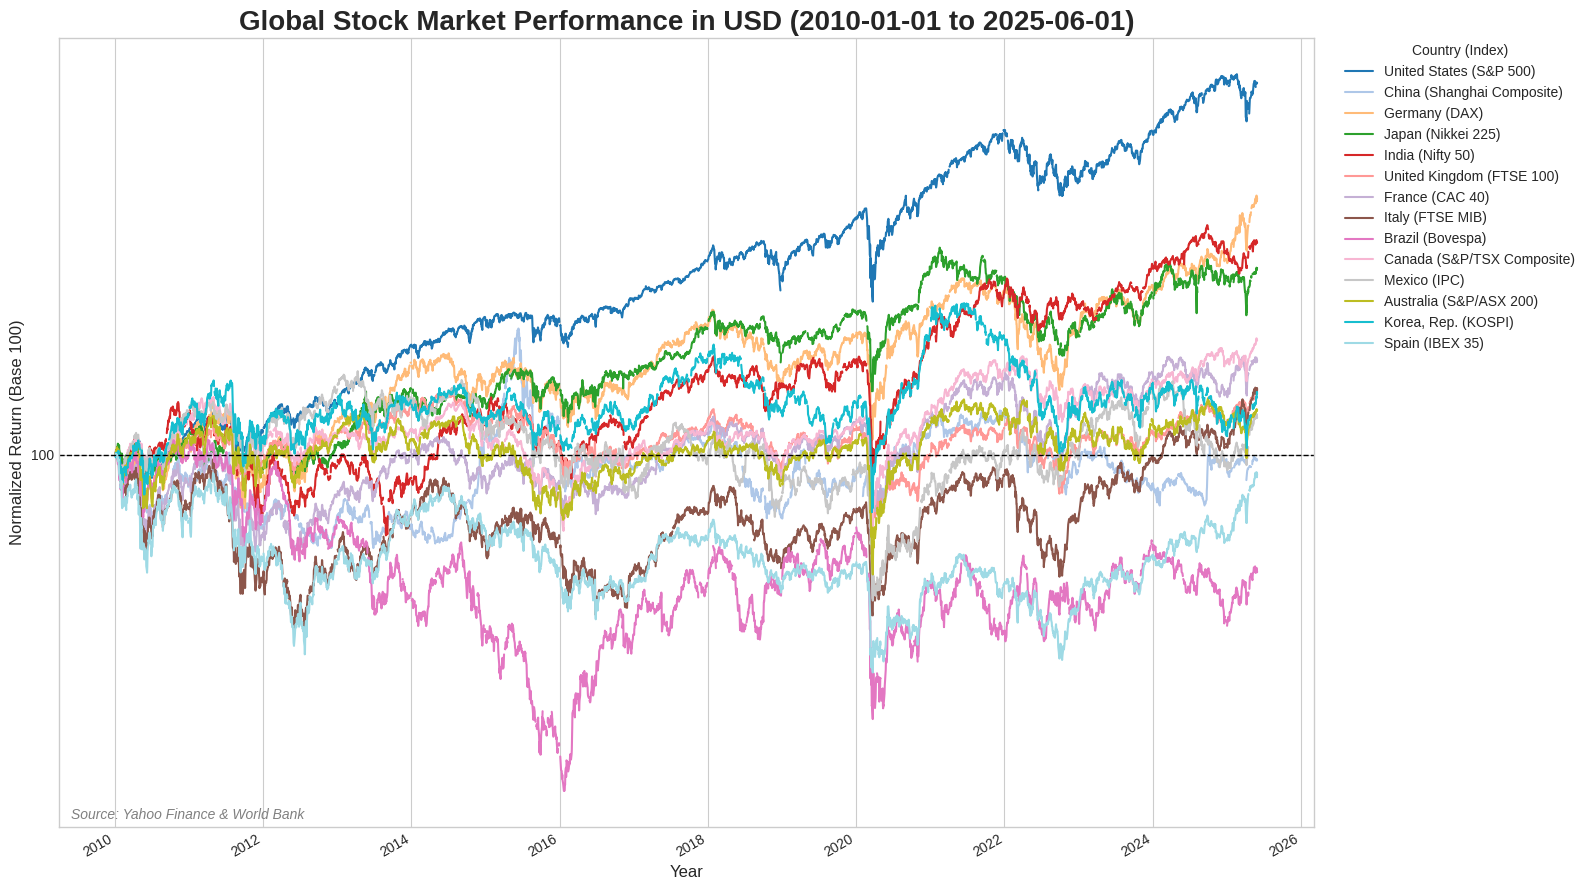

In [24]:
# In[5]:
# --- Plot the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 9))

# Plot each country's normalized return series
normalized_returns_df.plot(ax=ax, colormap='tab20')

# --- Formatting the Plot ---
# Add a horizontal line at 100 for reference
ax.axhline(100, color='black', linestyle='--', linewidth=1)

# Set title and labels
ax.set_title(f'Global Stock Market Performance in USD ({START_DATE} to {END_DATE})', fontsize=20, weight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Normalized Return (Base 100)', fontsize=12)

# Set logarithmic scale to better compare markets with different growth rates
ax.set_yscale('log')
from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.tick_params(axis='both', which='major', labelsize=10)


# Add a source annotation
ax.text(0.01, 0.01, 'Source: Yahoo Finance & World Bank', transform=ax.transAxes,
        fontsize=10, color='gray', style='italic')

# Improve the legend
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0., title='Country (Index)')

plt.tight_layout()
plt.show()